## Creating run_query(), run_command(),  and show_tables() functions

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

%matplotlib inline


def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql_query(q,conn)
    
def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)
def show_tables():
    q = """ SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");
"""
    return run_query(q)

# Running show_tables() function to return list of tables and
# views in database

print (show_tables())
show_tables()
    
    

              name   type
0            album  table
1           artist  table
2         customer  table
3         employee  table
4            genre  table
5          invoice  table
6     invoice_line  table
7       media_type  table
8         playlist  table
9   playlist_track  table
10           track  table


,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Writing query that returns number of tracks old for each genre

In [2]:
q = """


WITH
    customers AS
        (SELECT * FROM invoice i
        INNER JOIN customer c ON c.customer_id = i.customer_id
        WHERE country = "USA"
        GROUP BY 1
        ),
    inln AS
        (SELECT * FROM invoice_line il
        INNER JOIN customers c ON c.invoice_id = il.invoice_id
        ),
    tracks AS
        (SELECT * FROM genre g
        INNER JOIN track tr ON g.genre_id = tr.genre_id
        ),
    al AS
        (SELECT name genre, COUNT(trs.track_id) tracks_sold, invoice_line_id FROM tracks trs
        INNER JOIN inln ON inln.track_id = trs.track_id
        GROUP BY 1
        ORDER BY 2 DESC
        )
    
SELECT genre, tracks_sold, CAST(tracks_sold AS FLOAT) / 1051 percentage 
FROM al 
GROUP BY 1
ORDER BY 2 DESC;
    """

run_query(q)


,genre,tracks_sold,percentage
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


## Generating bar plot for the percent of tracks sold by genre in the US


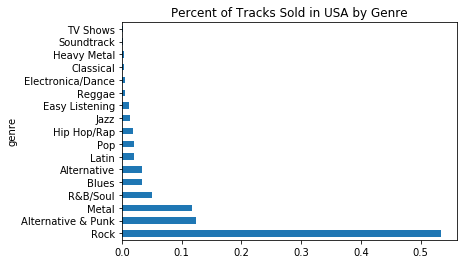

In [3]:
with sqlite3.connect('chinook.db') as conn:
    df = pd.read_sql_query(q,conn)

df.set_index("genre", inplace=True, drop=True)    
df["percentage"].plot.barh(
    title="Percent of Tracks Sold in USA by Genre"
)


## Generating bar plot for total tracks sold in the USA by genre

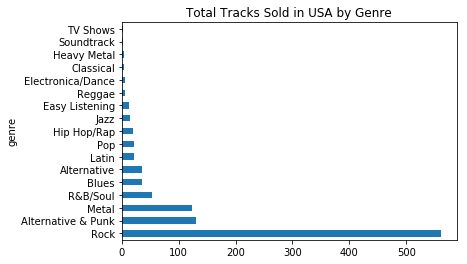

In [4]:
df["tracks_sold"].plot.barh(
    title="Total Tracks Sold in USA by Genre"
)

The Chinook record store wanted recommendations of which artist to sign based on which genre had higher sales. Out of the four artists they are looking at (Regal - Hip-Hop, Red Tone - Punk, Meteor and the Girls - Pop and Slim Jim Bites - Blues), I would recommend to sign Red Tone (Punk) and Slim Jim Bites (Blues) based on the percentages from previous sales.

## Writing query that find total dollar amount of sales assigned to each sales support agent
        

In [5]:
q = """
WITH 
    names AS
        (SELECT * FROM employee e 
        INNER JOIN customer c ON c.support_rep_id = e.employee_id
        INNER JOIN invoice i ON i.customer_id = c.customer_id
        )
   
SELECT SUM(total) total_amount_sold, first_name || " " || last_name name, title, hire_date FROM names GROUP BY 2 ORDER BY 4 DESC;
"""
run_query(q)

,total_amount_sold,name,title,hire_date
0,1393.92,Steve Johnson,Sales Support Agent,2017-10-17 00:00:00
1,1584.00,Margaret Park,Sales Support Agent,2017-05-03 00:00:00
2,1731.51,Jane Peacock,Sales Support Agent,2017-04-01 00:00:00


Based on the total dollar amounts, Jane Peacock has the highest value. However, when looking at the hire date for all employees, Jane was hired in April, Margaret in May and Steve in October of the same year. A better test would be to find the productivity over time for each employee. From a first glance, Steve has the highest productivity depending on what the date these statistics were gathered. 

## Generating plot of total dollar amount per sales employee

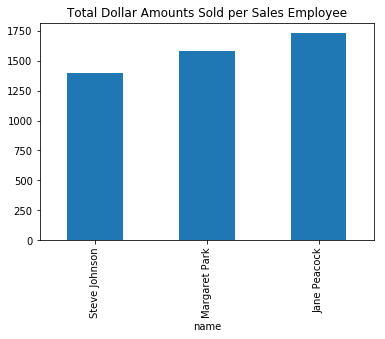

In [6]:
with sqlite3.connect('chinook.db') as conn:
    df = pd.read_sql_query(q,conn)

df.set_index("name", inplace=True, drop=True)    

df["total_amount_sold"].plot.bar(
    title="Total Dollar Amounts Sold per Sales Employee"
)
 


## Query that collates data on purchases from different countries

In [7]:
q = """
WITH 
    tot AS
        (SELECT * FROM customer c
        INNER JOIN invoice i ON i.customer_id = c.customer_id
        )
        
SELECT  
    SUM(total) amount, 
    country,
    COUNT(DISTINCT customer_id) customers,
    COUNT(*) number_of_purchases,
    CAST(SUM(total) AS FLOAT) / COUNT(*) average_price_per_purchase
FROM tot 
GROUP BY 2 
ORDER BY 3 DESC;
"""

run_query(q)

,amount,country,customers,number_of_purchases,average_price_per_purchase
0,1040.49,USA,13,131,7.942672
1,535.59,Canada,8,76,7.047237
2,427.68,Brazil,5,61,7.011148
3,389.07,France,5,50,7.781400
4,334.62,Germany,4,41,8.161463
5,245.52,United Kingdom,3,28,8.768571
6,273.24,Czech Republic,2,30,9.108000
7,183.15,India,2,21,8.721429
8,185.13,Portugal,2,29,6.383793
9,39.60,Argentina,1,5,7.920000


## Visualizing Sales by Country

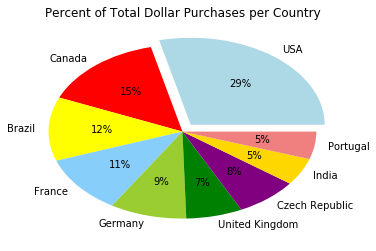

In [8]:
with sqlite3.connect('chinook.db') as conn:
    df = pd.read_sql_query(q,conn)

labels = df['country'][0:9]
sizes = df['amount'][0:9]
explode = (0.1, 0, 0, 0,0,0,0,0,0)
colors = ['lightblue', 'red', 'yellow', 'lightskyblue', 'yellowgreen', 'green', 'purple', 'gold', 'lightcoral']
fig, ax = plt.subplots()

df.set_index("country", inplace=True, drop=True)
ax.pie(sizes, labels=labels, explode=explode, colors=colors, autopct='%1.0f%%')
ax.set_title("Percent of Total Dollar Purchases per Country")
plt.show()

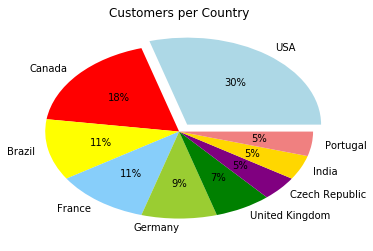

In [9]:
with sqlite3.connect('chinook.db') as conn:
    df = pd.read_sql_query(q,conn)

labels = df['country'][0:9]
sizes = df['customers'][0:9]
explode = (0.1, 0, 0, 0,0,0,0,0,0)
colors = ['lightblue', 'red', 'yellow', 'lightskyblue', 'yellowgreen', 'green', 'purple', 'gold', 'lightcoral']
fig, ax = plt.subplots()

df.set_index("country", inplace=True, drop=True)
ax.pie(sizes, labels=labels, explode=explode, colors=colors, autopct='%1.0f%%')
ax.set_title("Customers per Country")
plt.show()

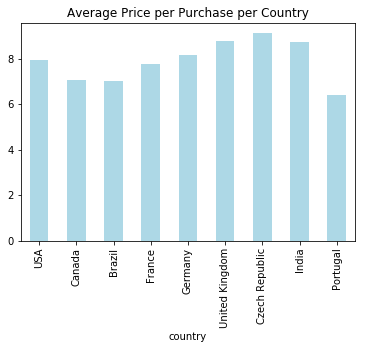

In [12]:
with sqlite3.connect('chinook.db') as conn:
    df = pd.read_sql_query(q,conn)

color = ['lightblue', 'red', 'yellow', 'lightskyblue', 'yellowgreen', 'green', 'purple', 'gold', 'lightcoral']
df.set_index("country", inplace=True, drop=True)
df['average_price_per_purchase'][0:9].plot.bar(
    title="Average Price per Purchase per Country", color=color)


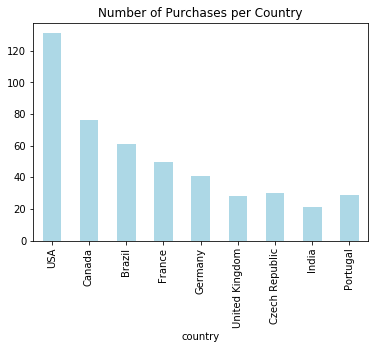

In [13]:
with sqlite3.connect('chinook.db') as conn:
    df = pd.read_sql_query(q,conn)

color = ['lightblue', 'red', 'yellow', 'lightskyblue', 'yellowgreen', 'green', 'purple', 'gold', 'lightcoral']
df.set_index("country", inplace=True, drop=True)
df['number_of_purchases'][0:9].plot.bar(
    title="Number of Purchases per Country", color=color)
